# Introduction

In this benchmarking challenge, you will be tasked to create an [AutoRA theorist](https://autoresearch.github.io/autora/theorist/) to discover equations that best describe a given data set.

You can use this notebook to benchmark your theorist based on 3 different datasets from 3 different cogntive models, respectively.








## Benchmarking Challenge Rules

- All contributing teams must publish a pip package of their theorist. We recommend using a pre-release.
- The package name must be ``autora-theorist-yourtheorist``
- The **theorist must have a fit and predict function**, and it must be **compatible with the synthetic models** in this notebook. We will call the following code to evaluate the theorists, except that we won't be using the Weber-Fechner-Law:

```python
pip install --pre <autora-theorist-yourtheorist>

from autora.theorist.yourtheorist import yourtheorist
from autora.experiment_runner.synthetic.psychophysics.weber_fechner_law import weber_fechner_law # this will be a secret ground truth model

experiment_runner = weber_fechner_law()
theorist = yourtheorist()

# generate all conditions
conditions = experiment_runner.domain()

# generate all corresponding observations
experiment_data = experiment_runner.run(conditions, added_noise=0.01)

# get the name of the independent and independent variables
ivs = [iv.name for iv in experiment_runner.variables.independent_variables]
dvs = [dv.name for dv in experiment_runner.variables.dependent_variables]

# extract the dependent variable (observations) from experiment data
conditions = experiment_data[ivs]
observations = experiment_data[dvs]

# split into train and test datasets
conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

# fit theorist
theorist.fit(conditions_train, observations_train)

# compute prediction for validation set
predictions = theorist.predict(conditions_test)

# evaluate theorist performance
error = (predictions - observations_test).pow(2)
error = error.mean()

theorist.print_eqn()


```

- Theorist also **must have a function ``print_eqn`` returning the discovered equation as a string.**
- The discovered equation **may not include more than 40 symbols/function elements**.
- Teams will be ranked based on the fit to two ground-truth models. Observations will be sampled across the entire domain of the ground-truth model. The rank will be accumulated across all benchmarking challenges. The team with the best accumulated rank will win a prize at the end of the workshop.
- The teams must provide a **brief presentation** (less than 5 minutes) of their theorist just before the final evaluation. You may use [this template for your slides](https://docs.google.com/presentation/d/1esmYO09ehiGOkzBsBAEf_wCfx2JrlmWwP7dyfpu0dEM/edit?usp=sharing).

*Hint: You may not use a search space including more than the following functions and operators.*
  - +
  - -
  - *
  - /
  - e^x
  - ln x
  - x^c
  - c (constants may appear)

## Grading

- Due date: **August 30**
- Submission: Through ``Stud.IP -> Tasks -> Equation Discovery Challenge``

The grading is independent of the outcome of the benchmarking challenge.

The following points will be provided:
- A demonstration of the theorist in the ``doc/Basic Usage.ipynb``:
  -  2 points: Demonstrating how to use the theorist for fitting
  -  2 points: Demonstrating how to use the theorist for predicting
  -  2 points: Demonstrating how to obtain the equation fit by the theorist
  -  4 points: Demonstrating that the theorist can recover at least two ground truth models. (*Hint: You could use the benchmarking part of the notebook below as a starting point*).
- The documentation of the theorist in ``doc/index.md`` must speak to the following information:
  - 2 points: Search Algorithm: a description of the search algorithm, and how the goodness of the equation was determined?
  - 2 points: Search Space: which search space was used and how was the search otherwise constrained?
- 2 points: The code contains at least two useful unit tests for the theorist method (either doc tests or separate tests)
- 1 point: the contributors used issues to track bugs and work on features.
- 1 point: the contributors used (helpful) code reviews for their PRs.
- 1 point: Unit tests are automatically executed when a pull request is created.
- 1 point: The documentation is hosted automatically.

Finally, teams must outline the contributions of each team member in their submission on ``Stud.IP -> Tasks -> Equation Discovery Challenge``.

In total, you can obtain 20 points.

## Additional Resources

- You can learn more about how to write AutoRA theorists in the [Contributor Guide](https://autoresearch.github.io/autora/contribute/modules/theorist/).

- You can learn more about how to use AutoRA in the [User Tutorial](https://autoresearch.github.io/autora/tutorials/).

- If you want to learn more about AutoRA states, you can check out [this tutorial on using AutoRA states](https://colab.research.google.com/drive/1yK1OBRpPZM1NgTMV9arHlE5j8xXjsGqq?usp=sharing).

# Code for Benchmarking your Theorist

## Installation

*Hint: You may want to add ``autora`` as a development dependency in your ``pyproject.tml``.*

In [1]:
%%capture
!pip install autora
!pip install autora[all-theorists]

## Imports

In [2]:
# autora state
from autora.state import StandardState, on_state, Delta

# experiment_runner
from autora.experiment_runner.synthetic.psychophysics.weber_fechner_law import weber_fechner_law
from autora.experiment_runner.synthetic.psychophysics.stevens_power_law import stevens_power_law
from autora.experiment_runner.synthetic.economics.expected_value_theory import expected_value_theory
from autora.experiment_runner.synthetic.psychology.luce_choice_ratio import luce_choice_ratio
from autora.experiment_runner.synthetic.psychology.q_learning import q_learning
from autora.experiment_runner.synthetic.psychology.exp_learning import exp_learning
from autora.experiment_runner.synthetic.economics.expected_value_theory import expected_value_theory
from autora.experiment_runner.synthetic.economics.prospect_theory import prospect_theory
from autora.experiment_runner.synthetic.abstract.lmm import lmm_experiment
from autora.experiment_runner.synthetic.abstract.template_experiment import template_experiment
from autora.experiment_runner.synthetic.neuroscience.task_switching import task_switching


# experimentalist
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_pool, random_sample

# data handling
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# *Add src folder onto sys.path
import sys, os

# assuming your notebook lives one level above src/
HERE = os.path.dirname(os.path.abspath("__file__"))
SRC  = os.path.join(HERE, "src")
sys.path.insert(0, SRC)

## Benchmarking Function

We will use the following function for benchmarking our model for any given experiment runner.

In [3]:
def benchmark(experiment_runner, theorist):

  # generate all conditions
  conditions = experiment_runner.domain()

  # generate all corresponding observations
  experiment_data = experiment_runner.run(conditions, added_noise=0.01)

  # get the name of the independent and independent variables
  ivs = [iv.name for iv in experiment_runner.variables.independent_variables]
  dvs = [dv.name for dv in experiment_runner.variables.dependent_variables]

  # extract the dependent variable (observations) from experiment data
  conditions = experiment_data[ivs]
  observations = experiment_data[dvs]

  # split into train and test datasets
  conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

  print("#### EXPERIMENT CONDITIONS (X):")
  print(conditions)
  print("#### EXPERIMENT OBSERVATIONS (Y):")
  print(observations)

  # fit theorist
  theorist.fit(conditions_train, observations_train)

  # compute prediction for validation set
  predictions = theorist.predict(conditions_test)

  # evaluate theorist performance
  error = (predictions - observations_test).pow(2)
  error = error.mean()

  print("#### IDENTIFIED EQUATION:")
  print(theorist.print_eqn())

  print("#### VALIDATION SET MSE:")
  print(error)

  experiment_runner.plotter(model=theorist)
  plt.show()

## Dummy Theorist

For demonstration purposes, we will use this dummy theorist below. However, to effectively benchmark *your* equation discovery method, you may instead import your theorist from ``.src.theorist`` and use it instead.

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
      self.poly = PolynomialFeatures(degree=degree, include_bias=False)
      self.model = LinearRegression()

    def fit(self, x, y):
      features = self.poly.fit_transform(x, y)
      self.model.fit(features, y)
      return self

    def predict(self, x):
      features = self.poly.fit_transform(x)
      return self.model.predict(features)

    def print_eqn(self):
        # Extract the coefficients and intercept
        coeffs = self.model.coef_
        intercept = self.model.intercept_

        # Handle multi-output case by iterating over each output's coefficients and intercept
        if coeffs.ndim > 1:
            for idx in range(coeffs.shape[0]):
                equation = f"y{idx+1} = {intercept[idx]:.3f}"
                feature_names = self.poly.get_feature_names_out()
                for coef, feature in zip(coeffs[idx], feature_names):
                    equation += f" + ({coef:.3f}) * {feature}"
                print(equation)
        else:
            equation = f"y = {intercept:.3f}"
            feature_names = self.poly.get_feature_names_out()
            for coef, feature in zip(coeffs, feature_names):
                equation += f" + ({coef:.3f}) * {feature}"
            print(equation)

dummy_theorist = PolynomialRegressor()

## Our theorist
Our theorist is a piecewise sparse symbolic model 

Our computation graph:

1. Gating (optional, piecewise): KMeans assigns each xx to a region cc (0–k−1k−1).

2. Feature transforms: For each region we compute simple, interpretable primitives of the inputs:
    fj(x)∈{xi,  xi2,  xixj,  ln⁡(xi+ϵ),  (xi+ϵ)c,  xi/(xi+xj+ϵ),  1/(xi+ϵ)}fj​(x)∈{xi​,xi2​,xi​xj​,ln(xi​+ϵ),(xi​+ϵ)c,xi​/(xi​+xj​+ϵ),1/(xi​+ϵ)}.

3. Sparse linear comb (learned):
    y^=βc,0+∑j∈Scβc,j fj(x)y^​=βc,0​+∑j∈Sc​​βc,j​fj​(x)
    where ScSc​ is a small subset chosen by OMP (sparsity).

4. Model selection: we search over degree (1 or 2) and #chunks kk, and pick the argmin of validation MSE + tiny complexity penalty, under a global ≤ 40-symbol budget.

So it’s a piecewise, linear-in-parameters, symbolic model built from allowed ops. Discovery happens by:

- Choosing the structure: number of chunks kk, which features are included (subset ScSc​), and degree.

- Estimating constants: the ββ coefficients (and fixed exponents if you include powers like 0.5,1.50.5,1.5).


**Acronyms**:

**OLS**: Ordinary Least Squares

- Fit all chosen features at once by minimizing squared error:
min⁡β∥y−Fβ∥2minβ​∥y−Fβ∥2. No sparsity by itself; every included feature gets a (usually non-zero) weight.

**OMP**: Orthogonal Matching Pursuit

- A greedy sparse method: it picks one feature at a time—the one most correlated with the current residual—then re-fits coefficients on the selected set (via least squares) and updates the residual. Repeat until you’ve picked k features (your cap) or the residual is tiny.


In [7]:
import numpy as np
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Feature library with allowed ops
# -------------------------------
class FeatureLibrary:
    """
    Allowed ops:
      - linear: x_i
      - degree<=2 polys: x_i^2, (optional) x_i*x_j
      - logs: ln(x_i + shift_i)
      - powers: (x_i + shift_i)^c for c in allowed_powers
    Safe for non-positive inputs via learned shifts.
    """
    def __init__(
        self,
        include_interactions=True,
        include_logs=True,
        allowed_powers=(0.5, 1.5),
        eps=1e-8,
        random_state=0,
    ):
        self.include_interactions = include_interactions
        self.include_logs = include_logs
        self.allowed_powers = tuple(float(c) for c in allowed_powers)
        self.eps = float(eps)
        self.random_state = random_state
        self.log_shifts_ = None
        self.pow_shifts_ = None
        self.n_features_in_ = None

    def _ensure_2d(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return X

    def fit(self, X):
        X = self._ensure_2d(X)
        self.n_features_in_ = X.shape[1]
        mins = np.nanmin(X, axis=0)
        self.log_shifts_ = np.maximum(self.eps - mins, 0.0)
        self.pow_shifts_ = np.maximum(self.eps - mins, 0.0)
        return self

    def transform(self, X, degree=2):
        assert self.n_features_in_ is not None, "Call fit() first."
        X = self._ensure_2d(X)
        n, d = X.shape
        assert d == self.n_features_in_, "Feature dimension mismatch."

        feats, names = [], []

        # linear
        for i in range(d):
            feats.append(X[:, i:i+1])
            names.append(f"x{i}")

        # degree-2
        if degree >= 2:
            for i in range(d):
                feats.append(X[:, i:i+1] ** 2)
                names.append(f"x{i}^2")
            if self.include_interactions and d > 1:
                for i, j in combinations(range(d), 2):
                    feats.append((X[:, i:i+1] * X[:, j:j+1]))
                    names.append(f"x{i}*x{j}")

        # logs
        if self.include_logs:
            for i in range(d):
                shifted = np.maximum(X[:, i] + self.log_shifts_[i], self.eps)
                feats.append(np.log(shifted).reshape(-1, 1))
                s = self.log_shifts_[i]
                names.append(f"ln(x{i}+{s:.3g})" if s > 0 else f"ln(x{i})")

        # small power set
        for c in self.allowed_powers:
            if abs(c - 1.0) < 1e-12:
                continue
            for i in range(d):
                shifted = np.maximum(X[:, i] + self.pow_shifts_[i], self.eps)
                feats.append((shifted ** c).reshape(-1, 1))
                s = self.pow_shifts_[i]
                names.append(f"(x{i}+{s:.3g})^{c:.3g}" if s > 0 else f"x{i}^{c:.3g}")

        F = np.hstack(feats) if feats else np.empty((n, 0))
        return F, names


# -----------------------------------------------
# Sparse linear model (OMP) + OLS refit on support
# -----------------------------------------------
class SparseLinearBlock:
    """
    Select up to term_cap features via OMP (on standardized features),
    then refit OLS on the selected features (original scale).
    Handles multi-output by unioning supports and pruning to term_cap.
    """
    def __init__(self, term_cap=6, random_state=0):
        self.term_cap = int(term_cap)
        self.random_state = random_state
        self.active_idx_ = None
        self.lr_ = None
        self.feature_names_ = None
        self.coef_ = None
        self.intercept_ = None

    def fit(self, F, y, feature_names):
        F = np.asarray(F); y = np.asarray(y)
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        # standardize F (mean-0, unit-var), center y (mean-0)
        scalerF = StandardScaler(with_mean=True, with_std=True)
        Fy = scalerF.fit_transform(F)
        y_mean = y.mean(axis=0, keepdims=True)
        y_c = y - y_mean

        # OMP per target -> union support
        max_atoms = max(1, min(self.term_cap, Fy.shape[1], max(1, Fy.shape[0] - 1)))
        supports = []
        coef_store = []  # to score features if we need to prune
        for t in range(y_c.shape[1]):
            omp = OrthogonalMatchingPursuit(
                n_nonzero_coefs=max_atoms,
                fit_intercept=False,  # we centered y and standardized X
            )
            omp.fit(Fy, y_c[:, t])
            coef = getattr(omp, "coef_", None)
            if coef is None:
                continue
            coef_store.append(np.abs(coef))
            supports.append(set(np.flatnonzero(np.abs(coef) > 0).tolist()))

        if supports:
            active = sorted(list(set.union(*supports)))
        else:
            active = []

        # If nothing selected, pick best by correlation
        if len(active) == 0:
            corr = np.abs(Fy.T @ y_c).sum(axis=1)  # aggregate over targets
            best = int(np.argmax(corr))
            active = [best]

        # Prune union to term_cap if needed (by aggregate correlation with y)
        if len(active) > self.term_cap:
            corr = np.abs(Fy.T @ y_c).sum(axis=1)
            order = np.argsort(-corr[active])  # descending
            active = [active[i] for i in order[: self.term_cap]]

        self.active_idx_ = np.array(active, dtype=int)

        # OLS refit on selected features (original scale)
        F_sel = F[:, self.active_idx_]
        lr = LinearRegression()
        lr.fit(F_sel, y)
        self.lr_ = lr
        self.feature_names_ = [feature_names[j] for j in self.active_idx_]

        coef = lr.coef_
        if coef.ndim == 1:
            coef = coef.reshape(1, -1)
        self.coef_ = coef
        self.intercept_ = lr.intercept_.ravel()
        return self

    def predict(self, F):
        F = np.asarray(F)
        F_sel = F[:, self.active_idx_]
        return self.lr_.predict(F_sel)

    def n_terms(self):
        return 0 if self.active_idx_ is None else len(self.active_idx_)


# --------------------------------------------------------
# Chunked sparse polynomial regressor with symbol budgeting
# --------------------------------------------------------
class ChunkedPolynomialRegressorSparse:
    """
    Piecewise sparse regression with global symbol budget.
    Search: degree ∈ {1,2}, k ∈ {0..max_chunks}.
    """
    def __init__(
        self,
        max_chunks=4,
        max_degree=2,
        max_symbols=40,
        include_interactions=True,
        include_logs=True,
        allowed_powers=(0.5, 1.5),
        lambda_complexity=1e-4,
        random_state=0,
    ):
        self.max_chunks = int(max_chunks)
        self.max_degree = int(max_degree)
        self.max_symbols = int(max_symbols)
        self.lambda_complexity = float(lambda_complexity)
        self.random_state = random_state

        self.library = FeatureLibrary(
            include_interactions=include_interactions,
            include_logs=include_logs,
            allowed_powers=allowed_powers,
            random_state=random_state,
        )

        self.best_degree = None
        self.best_k = None
        self.clusterer = None
        self.cluster_labels = None
        self.cluster_scaler_ = None  # <-- store scaler used for clustering
        self.blocks = []
        self.feature_names_ = None
        self.mse_per_config = {}

        self.X_fit = None
        self.y_fit = None

    def _symbol_count(self, blocks):
        # 1 intercept per chunk + #selected terms
        return sum(1 + b.n_terms() for b in blocks)

    def _fit_blocks_for_k(self, X, y, degree, k):
        n = X.shape[0]

        if k == 0:
            labels = np.zeros(n, dtype=int)
            clusterer = None
            self.cluster_scaler_ = None
            per_chunk_cap = max(1, self.max_symbols - 1)
        else:
            # scaler & kmeans on training data; store scaler
            self.cluster_scaler_ = StandardScaler(with_mean=True, with_std=True).fit(X)
            Xs = self.cluster_scaler_.transform(X)
            clusterer = KMeans(n_clusters=k, n_init=10, random_state=self.random_state)
            labels = clusterer.fit_predict(Xs)
            # conservative per-chunk cap so total <= max_symbols
            per_chunk_cap = max(1, (self.max_symbols - k) // k)

        blocks = []
        preds = np.zeros_like(y, dtype=float)
        n_chunks = 1 if k == 0 else k

        for cid in range(n_chunks):
            idx = np.where(labels == cid)[0]
            if idx.size == 0:
                return None, None, np.inf, np.inf

            F, names = self.library.transform(X[idx], degree=degree)
            if F.shape[1] == 0:
                return None, None, np.inf, np.inf

            # Cap term_cap to available features/samples (extra safety for OMP)
            safe_cap = max(1, min(per_chunk_cap, F.shape[1], max(1, F.shape[0] - 1)))
            block = SparseLinearBlock(term_cap=safe_cap, random_state=self.random_state)
            block.fit(F, y[idx], names)

            preds[idx] = block.predict(F)
            blocks.append(block)

        # budget check
        scount = self._symbol_count(blocks)
        if scount > self.max_symbols:
            return None, None, np.inf, np.inf

        mse = mean_squared_error(y, preds)
        return blocks, (clusterer, labels), mse, scount

    def fit(self, X, y):
        X = np.asarray(X); y = np.asarray(y)
        if X.ndim == 1: X = X.reshape(-1, 1)
        if y.ndim == 1: y = y.reshape(-1, 1)

        self.X_fit = X
        self.y_fit = y
        self.library.fit(X)

        best = None
        best_score = np.inf
        self.mse_per_config = {}

        max_k = min(self.max_chunks, X.shape[0])

        for degree in range(1, self.max_degree + 1):
            for k in range(0, max_k + 1):
                blocks, pack, mse, scount = self._fit_blocks_for_k(X, y, degree, k)
                self.mse_per_config[(degree, k)] = (mse, scount)
                if not np.isfinite(mse):
                    continue
                score = mse + self.lambda_complexity * scount
                if score < best_score - 1e-12:
                    best_score = score
                    best = (degree, k, blocks, pack)

        if best is None:
            raise RuntimeError("❌ No feasible (degree, k) under the symbol budget.")

        self.best_degree, self.best_k, self.blocks, pack = best
        if self.best_k == 0:
            self.clusterer, self.cluster_labels = None, np.zeros(X.shape[0], dtype=int)
            self.cluster_scaler_ = None
        else:
            self.clusterer, self.cluster_labels = pack

        # cache names for printing (consistent for a given degree)
        _, names_tmp = self.library.transform(X, degree=self.best_degree)
        self.feature_names_ = names_tmp
        return self

    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 1: X = X.reshape(-1, 1)

        if self.best_k == 0:
            F, _ = self.library.transform(X, degree=self.best_degree)
            return self.blocks[0].predict(F)

        # use the SAME scaler used at fit-time for clustering
        Xs_new = self.cluster_scaler_.transform(X)
        labels = self.clusterer.predict(Xs_new)

        yhat = np.zeros((X.shape[0], self.y_fit.shape[1]))
        for cid, block in enumerate(self.blocks):
            idx = np.where(labels == cid)[0]
            if idx.size == 0:
                continue
            F, _ = self.library.transform(X[idx], degree=self.best_degree)
            yhat[idx] = block.predict(F)
        return yhat

    # Print the clusters
    def print_clusters(self, feature_names=None, quantiles=(0, 50, 100), digits=5):
        """
        Describe KMeans clusters in original input units.
        - feature_names: list like ['S1','S2'] (defaults to ['x0','x1',...])
        - quantiles: which percentiles to report per feature (e.g., (5,50,95))
        """
        if self.best_k == 0 or self.clusterer is None:
            print("No clustering: global model (k=0).")
            return

        X = self.X_fit
        n, d = X.shape
        names = feature_names or [f"x{i}" for i in range(d)]

        # Labels for training data using the stored scaler
        labels = self.clusterer.predict(self.cluster_scaler_.transform(X))

        # Centroids back in original units
        centers_std = self.clusterer.cluster_centers_
        centers_orig = self.cluster_scaler_.inverse_transform(centers_std)

        print(f"\n🔎 Cluster summary (k={self.best_k}):")
        for cid in range(self.best_k):
            idx = np.where(labels == cid)[0]
            if idx.size == 0:
                print(f"\n  • Region {cid+1}: [empty]")
                continue

            Xc = X[idx]
            c = centers_orig[cid]
            print(f"\n  • Region {cid+1}: n={len(idx)}")
            print("    center: " + ", ".join(f"{names[j]}={c[j]:.{digits}g}" for j in range(d)))

            # Per-feature quantile ranges in original units
            for j in range(d):
                qs = np.percentile(Xc[:, j], q=list(quantiles))
                qstr = " | ".join([f"q{int(q)}={val:.{digits}g}" for q, val in zip(quantiles, qs)])
                print(f"    {names[j]}: {qstr}")

            # Mean radius in standardized space (how tight the cluster is)
            dists = np.linalg.norm(self.cluster_scaler_.transform(Xc) - centers_std[cid], axis=1)
            print(f"    mean radius (std units): {np.mean(dists):.{digits}g} ± {np.std(dists):.{digits}g}")

        # For 1D, also print approximate cutpoints (midpoints between sorted centroids)
        if d == 1:
            order = np.argsort(centers_orig[:, 0])
            cuts = [(centers_orig[order[i], 0] + centers_orig[order[i+1], 0]) / 2
                    for i in range(len(order) - 1)]
            if cuts:
                print("\n  approx cutpoints (1D): " + ", ".join(f"{v:.{digits}g}" for v in cuts))

    # ------------- pretty printing -------------
    def _equation_str(self, block, out_idx=0):
        coef = block.coef_[out_idx]
        if coef.size == 0:
            return f"y{out_idx+1} = {block.intercept_[out_idx]:.6g}"
        terms = [f"({c:.6g})*{name}" for c, name in zip(coef, block.feature_names_)]
        return f"y{out_idx+1} = {block.intercept_[out_idx]:.6g} + " + " + ".join(terms)

    def print_eqn(self, max_outputs=1):
        print("\n📊 Scores for (degree, chunks):")
        for (deg, k), (mse, scount) in sorted(self.mse_per_config.items()):
            mark = " (global)" if k == 0 else ""
            print(f"  - degree={deg}, k={k}{mark}: MSE={mse:.6g}, symbols={scount}")

        print(f"\n✅ Final selection: degree={self.best_degree}, chunk count={self.best_k}")
        total_symbols = self._symbol_count(self.blocks)
        print(f"   Total symbols: {total_symbols} (budget ≤ {self.max_symbols})")

        # brief cluster summary so the regions are interpretable
        if self.best_k > 0:
            # pass raw feature names if you have them, e.g. ['S1','S2']
            self.print_clusters(feature_names=None, quantiles=(5, 50, 95))

        if self.best_k == 0:
            preds = self.predict(self.X_fit)
            mse = mean_squared_error(self.y_fit, preds)
            print(f"\n🔹 Global Model: n={len(self.X_fit)}, MSE={mse:.6g}")
            for j in range(min(max_outputs, self.y_fit.shape[1])):
                print(self._equation_str(self.blocks[0], out_idx=j))
            return

        # piecewise: recompute training labels with stored scaler
        labels = self.clusterer.predict(self.cluster_scaler_.transform(self.X_fit))
        for cid, block in enumerate(self.blocks):
            idx = np.where(labels == cid)[0]
            if idx.size == 0:
                print(f"\n🔹 Region {cid+1}: [Empty]")
                continue
            preds = self.predict(self.X_fit[idx])
            mse = mean_squared_error(self.y_fit[idx], preds)
            print(f"\n🔹 Region {cid+1}: n={len(idx)}, MSE={mse:.6g}")
            for j in range(min(max_outputs, self.y_fit.shape[1])):
                print(self._equation_str(block, out_idx=j))


# -----------------------------
# Instantiate your new theorist
# -----------------------------
chunk_theorist = ChunkedPolynomialRegressorSparse(
    max_chunks=4,
    max_degree=2,
    max_symbols=36,
    include_interactions=True,
    include_logs=True,
    allowed_powers=(0.5, 1.5),
    lambda_complexity=1e-4,
    random_state=0,
)

In [ ]:
# *Add src folder onto sys.path
import sys, os

# assuming your notebook lives one level above src/
HERE = os.path.dirname(os.path.abspath("__file__"))
SRC  = os.path.join(HERE, "src")
sys.path.insert(0, SRC)

In [ ]:
os.getcwd()

'/workspaces/autora-theorist-MAFT/challenge'

In [ ]:
from autora.theorist.maft import ChunkedPolynomialRegressorSparse

theorist = ChunkedPolynomialRegressorSparse(
    max_chunks=4,
    max_degree=2,
    max_symbols=36,
    include_interactions=True,
    include_logs=True,
    allowed_powers=(0.5, 1.5),
    lambda_complexity=1e-4,
    random_state=0,
)

ModuleNotFoundError: No module named 'autora.theorist.maft'

In [ ]:
os.chdir('../')
os.getcwd()
os.chdir('autora-theorist-MAFT')

FileNotFoundError: [Errno 2] No such file or directory: 'autora-theorist-MAFT'

## Ground-Truth Models for Benchmarking



### **Benchmarking Combined**

#### EXPERIMENT CONDITIONS (X):
           S
0   0.010000
1   0.060404
2   0.110808
3   0.161212
4   0.211616
..       ...
95  4.798384
96  4.848788
97  4.899192
98  4.949596
99  5.000000

[100 rows x 1 columns]
#### EXPERIMENT OBSERVATIONS (Y):
    perceived_intensity
0              0.030946
1              0.101733
2              0.173936
3              0.225267
4              0.276496
..                  ...
95             3.522879
96             3.537325
97             3.567371
98             3.603107
99             3.612736

[100 rows x 1 columns]
#### IDENTIFIED EQUATION:

📊 Scores for (degree, chunks):
  - degree=1, k=0 (global): MSE=0.00010524, symbols=5
  - degree=1, k=1: MSE=0.00010524, symbols=5
  - degree=1, k=2: MSE=0.000102311, symbols=10
  - degree=1, k=3: MSE=9.49718e-05, symbols=15
  - degree=1, k=4: MSE=8.89865e-05, symbols=20
  - degree=2, k=0 (global): MSE=0.000105188, symbols=6
  - degree=2, k=1: MSE=0.000105188, symbols=6
  - degree=2, k=2: MSE=0.000100618, symbols

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


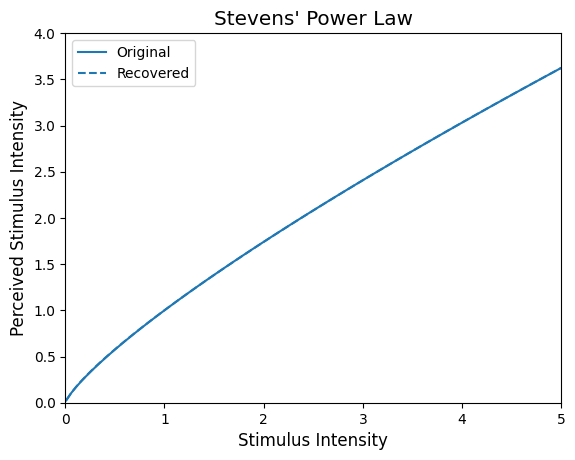

#### EXPERIMENT CONDITIONS (X):
            S1        S2
0     0.010000  0.010000
1     0.010000  0.060404
2     0.010000  0.110808
3     0.010000  0.161212
4     0.010000  0.211616
...        ...       ...
5045  4.899192  4.949596
5046  4.899192  5.000000
5047  4.949596  4.949596
5048  4.949596  5.000000
5049  5.000000  5.000000

[5050 rows x 2 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      difference_detected
0                0.005147
1                1.797525
2                2.377260
3                2.763042
4                3.069737
...                   ...
5045             0.005141
5046             0.026743
5047            -0.007446
5048             0.023978
5049             0.005433

[5050 rows x 1 columns]
#### IDENTIFIED EQUATION:

📊 Scores for (degree, chunks):
  - degree=1, k=0 (global): MSE=9.66415e-05, symbols=9
  - degree=1, k=1: MSE=9.66415e-05, symbols=9
  - degree=1, k=2: MSE=9.64341e-05, symbols=18
  - degree=1, k=3: MSE=9.6347e-05, symbols=27
  - degree=1, k=4: M

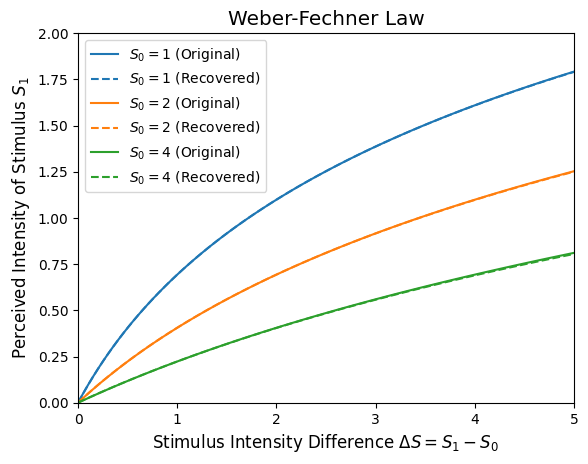

#### EXPERIMENT CONDITIONS (X):
        V_A       P_A       V_B       P_B
0 -1.000000 -0.777778 -0.555556 -0.333333
1 -0.111111  0.111111  0.333333  0.555556
2  0.777778  1.000000  0.000000  0.111111
3  0.222222  0.333333  0.444444  0.555556
4  0.666667  0.777778  0.888889  1.000000
5 -1.000000 -0.777778 -0.555556 -0.333333
6 -0.111111  0.111111  0.333333  0.555556
7  0.777778  1.000000  0.000000  0.111111
8  0.222222  0.333333  0.444444  0.555556
9  0.666667  0.777778  0.888889  1.000000
#### EXPERIMENT OBSERVATIONS (Y):
   choose_A
0  0.958599
1  0.278218
2  0.979270
3  0.293735
4  0.134163
5  0.957870
6  0.232170
7  0.977754
8  0.299638
9  0.145605
#### IDENTIFIED EQUATION:

📊 Scores for (degree, chunks):
  - degree=1, k=0 (global): MSE=0.000151496, symbols=5
  - degree=1, k=1: MSE=0.000151496, symbols=5
  - degree=1, k=2: MSE=0.000151496, symbols=7
  - degree=1, k=3: MSE=0.000151496, symbols=7
  - degree=1, k=4: MSE=0.000151496, symbols=8
  - degree=2, k=0 (global): MSE=0.000151496

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested pr

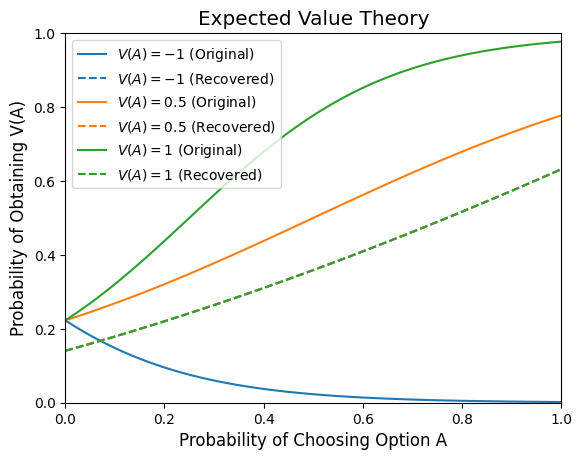

#### EXPERIMENT CONDITIONS (X):
      similarity_category_A1  similarity_category_A2  similarity_category_B1  \
0                        0.1                0.100000                     0.1   
1                        0.1                1.514286                     0.1   
2                        0.1                2.928571                     0.1   
3                        0.1                4.342857                     0.1   
4                        0.1                5.757143                     0.1   
...                      ...                     ...                     ...   
4091                    10.0                4.342857                    10.0   
4092                    10.0                5.757143                    10.0   
4093                    10.0                7.171429                    10.0   
4094                    10.0                8.585714                    10.0   
4095                    10.0               10.000000                    10.0   

      s

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


#### IDENTIFIED EQUATION:

📊 Scores for (degree, chunks):
  - degree=1, k=0 (global): MSE=0.00222481, symbols=17
  - degree=1, k=1: MSE=0.00222481, symbols=17
  - degree=1, k=2: MSE=0.00193433, symbols=32
  - degree=1, k=3: MSE=0.00148653, symbols=36
  - degree=1, k=4: MSE=0.00156732, symbols=36
  - degree=2, k=0 (global): MSE=0.0010845, symbols=27
  - degree=2, k=1: MSE=0.0010845, symbols=27
  - degree=2, k=2: MSE=0.000986665, symbols=36
  - degree=2, k=3: MSE=0.000695708, symbols=36
  - degree=2, k=4: MSE=0.000725673, symbols=36

✅ Final selection: degree=2, chunk count=0
   Total symbols: 27 (budget ≤ 36)

🔹 Global Model: n=3072, MSE=0.0010845
y1 = -0.474399 + (0.00654813)*x0 + (-0.00921061)*x1 + (-0.0760359)*x2 + (-0.519484)*x3 + (0.000992861)*x0^2 + (-0.000758536)*x1^2 + (-0.000672394)*x2^2 + (-0.0141413)*x3^2 + (-0.00228353)*x0*x1 + (-0.000465374)*x0*x2 + (-0.00045766)*x0*x3 + (0.00148422)*x1*x2 + (0.00150722)*x1*x3 + (0.000486736)*x2*x3 + (-0.0506677)*ln(x0) + (0.0299264)*ln(x1)

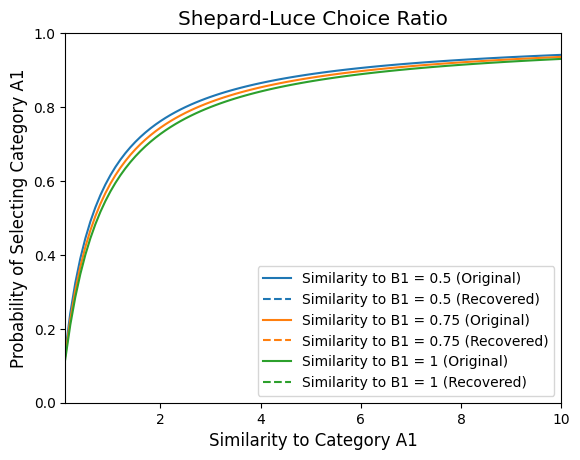

#### EXPERIMENT CONDITIONS (X):
      P_asymptotic  trial
0              0.0    1.0
1              0.0    2.0
2              0.0    3.0
3              0.0    4.0
4              0.0    5.0
...            ...    ...
9995           0.5   96.0
9996           0.5   97.0
9997           0.5   98.0
9998           0.5   99.0
9999           0.5  100.0

[10000 rows x 2 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      performance
0        0.030647
1        0.062651
2        0.115242
3        0.106917
4        0.131786
...           ...
9995     0.971887
9996     0.966423
9997     0.962738
9998     0.978278
9999     0.970237

[10000 rows x 1 columns]
#### IDENTIFIED EQUATION:

📊 Scores for (degree, chunks):
  - degree=1, k=0 (global): MSE=0.00146926, symbols=9
  - degree=1, k=1: MSE=0.00146926, symbols=9
  - degree=1, k=2: MSE=0.000439071, symbols=18
  - degree=1, k=3: MSE=0.000305366, symbols=27
  - degree=1, k=4: MSE=0.000228888, symbols=36
  - degree=2, k=0 (global): MSE=0.000264309, symbols=12


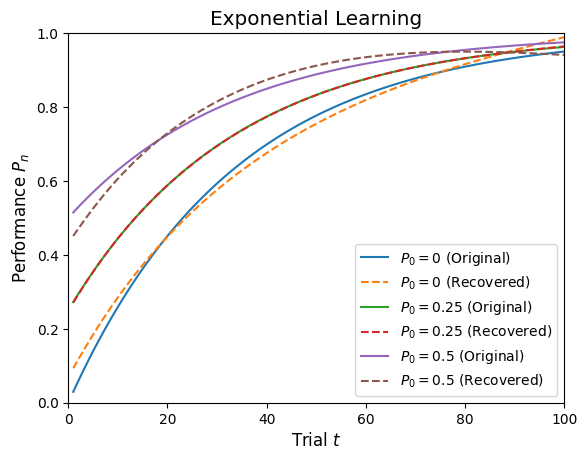

#### EXPERIMENT CONDITIONS (X):
      V_A       P_A  V_B  P_B
0    -1.0  0.000000 -1.0  0.0
1    -1.0  0.111111 -1.0  0.0
2    -1.0  0.222222 -1.0  0.0
3    -1.0  0.333333 -1.0  0.0
4    -1.0  0.444444 -1.0  0.0
...   ...       ...  ...  ...
9995  1.0  0.555556  1.0  1.0
9996  1.0  0.666667  1.0  1.0
9997  1.0  0.777778  1.0  1.0
9998  1.0  0.888889  1.0  1.0
9999  1.0  1.000000  1.0  1.0

[10000 rows x 4 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      choose_A
0     0.541830
1     0.016217
2     0.002490
3     0.000298
4     0.000072
...        ...
9995  0.003127
9996  0.006761
9997  0.015779
9998  0.047900
9999  0.535393

[10000 rows x 1 columns]
#### IDENTIFIED EQUATION:

📊 Scores for (degree, chunks):
  - degree=1, k=0 (global): MSE=0.0655424, symbols=17
  - degree=1, k=1: MSE=0.0655424, symbols=17
  - degree=1, k=2: MSE=0.042551, symbols=34
  - degree=1, k=3: MSE=0.0407202, symbols=36
  - degree=1, k=4: MSE=0.037934, symbols=36
  - degree=2, k=0 (global): MSE=0.0346349, symbols=2

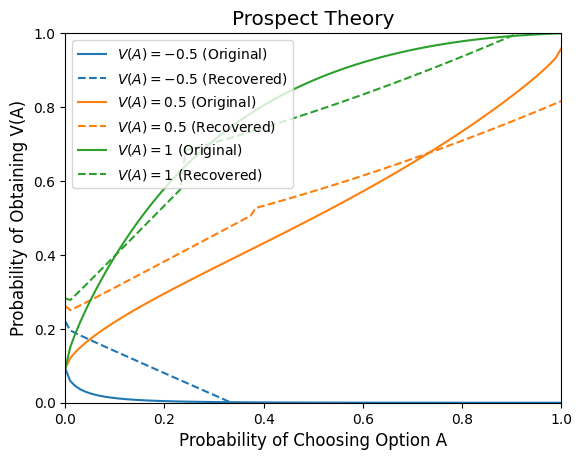

#### EXPERIMENT CONDITIONS (X):
      cur_task_strength  alt_task_strength  is_switch
0                  0.02               0.02        0.0
1                  0.02               0.04        0.0
2                  0.02               0.06        0.0
3                  0.02               0.08        0.0
4                  0.02               0.10        0.0
...                 ...                ...        ...
4995               1.00               0.92        1.0
4996               1.00               0.94        1.0
4997               1.00               0.96        1.0
4998               1.00               0.98        1.0
4999               1.00               1.00        1.0

[5000 rows x 3 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      cur_task_performance
0                 0.921844
1                 0.901630
2                 0.883268
3                 0.867921
4                 0.861810
...                    ...
4995              0.531972
4996              0.538006
4997              

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linea

#### IDENTIFIED EQUATION:

📊 Scores for (degree, chunks):
  - degree=1, k=0 (global): MSE=0.000957259, symbols=10
  - degree=1, k=1: MSE=0.000957259, symbols=10
  - degree=1, k=2: MSE=0.000160481, symbols=18
  - degree=1, k=3: MSE=0.000142078, symbols=27
  - degree=1, k=4: MSE=0.000101463, symbols=36
  - degree=2, k=0 (global): MSE=0.000618372, symbols=15
  - degree=2, k=1: MSE=0.000618372, symbols=15
  - degree=2, k=2: MSE=0.000106427, symbols=24
  - degree=2, k=3: MSE=0.000101164, symbols=36
  - degree=2, k=4: MSE=5.93168e-05, symbols=36

✅ Final selection: degree=1, chunk count=0
   Total symbols: 10 (budget ≤ 36)

🔹 Global Model: n=3750, MSE=0.000957259
y1 = 1.18938 + (2.7077)*x0 + (-2.21392)*x1 + (0.136542)*ln(x0) + (-0.0773748)*ln(x1) + (-0.00831245)*ln(x2+1e-08) + (-2.47956)*x0^0.5 + (1.39674)*x1^0.5 + (-0.981456)*x0^1.5 + (0.887196)*x1^1.5
None
#### VALIDATION SET MSE:
cur_task_performance    0.000997
dtype: float64


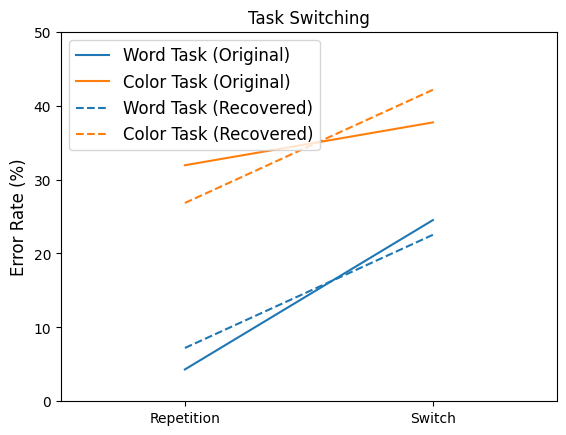

In [8]:
#########################################
######## Bench-Marking Combined #########
#########################################

## AHMED: This runs all the ones we tried in one go!

# Benchmark 1) stevens_power_law
# Benchmark 2) weber_fechner_law
# Benchmark 3) expected_value_theory

# luce_choice_ratio
# exp_learning
# prospect_theory
# task_switching


# run benchmark
# add "expected_value_theory" later on. Our theorist (bic version) cannot handle when there are less rows than columns.
experiment_runners = [stevens_power_law, weber_fechner_law, expected_value_theory, luce_choice_ratio, exp_learning, prospect_theory, task_switching]
for experiment in experiment_runners:
    benchmark(experiment_runner = experiment(), theorist = chunk_theorist)

### **Steven's Power Law**

Steven's power law describes the relationship between a stimulus's intensity $S$ ($range: [0.01, 5.00]$) and its perceived magnitude $y$. According to this law, humans are less sensitive to changes in high-intensity stimuli compared to low-intensity ones, leading to a power-law relationship between stimulus intensity and perceived magnitude:


$\text{perceived intensity} = {S}^\alpha$

where $\alpha = 0.80$, resulting in diminishing effects of increases in stimulus intensity.

In [ ]:
# run benchmark
benchmark(experiment_runner = stevens_power_law(), theorist = dummy_theorist)

### **Weber-Fechner-Law**

The Weber-Fechner law quantifies the minimum change in a stimulus required to be noticeable. Similar to Steven's power law, the greater the intensity of a stimulus, the larger the change needed to be perceivable. This relationship is hypothesized to be proportional to the logarithm of the ratio between the two stimuli:

$\text{perceived intensity} = \log\left(\dfrac{S_1}{S_2}\right)$


where $S_1$ ($range: [0.01, 5.00]$) is the intensity of a physical stimulus (e.g., the luminosity of a lamp), $S_2$ ($range: [0.01, 5.00]$ ) is a reference stimulus (e.g., the luminosity of a background light), and $y$ is the perceived stimulus intensity (e.g. the perception of the lamp's luminosity).

In [ ]:
# run benchmark
benchmark(experiment_runner = weber_fechner_law(), theorist = dummy_theorist)

### **Expected Utility Model with Two Choice Options**

The expected utility model evaluates decision-making under uncertainty, quantifying the expected value of different choices based on their potential outcomes and associated probabilities. The model assumes that individuals aim to maximize their expected utility when faced with two options. Each option has a specific value and probability, influenced by a certain level of noise.

For two choice options, the expected value of each option is calculated as follows:

$$
E_A = V_A \times P_A
$$

$$
E_B = V_B \times P_B
$$

where:
- $V_A$ and $V_B$ represent the values of options A and B respectively.
- $P_A$ and $P_B$ represent the probabilities associated with these options.

The probability of choosing option A $P_{\text{choose}_A}$ is then determined using the softmax function, which considers the expected values of both options and a choice temperature parameter that influences the sensitivity to differences in expected values:

$$
P_{\text{choose}_A} = \frac{\exp(E_A / \beta)}{\exp(E_A / \beta) + \exp(E_B / \beta)}
$$

In this model:
- $\beta$ controls the degree of randomness in the choice, with higher values leading to more exploration and lower values leading to more deterministic choices based on the expected values.
- The softmax function ensures that the probabilities sum to 1, providing a normalized measure of the likelihood of choosing each option.

This model captures the influence of value, probability, and noise on decision-making, reflecting the complexity and variability of human choices under uncertainty.



In [ ]:
# run benchmark
benchmark(experiment_runner = expected_value_theory(), theorist = dummy_theorist)

In [ ]:
import numpy as np

# Define inputs (2 features)
x = np.array([
    [1, 1],
    [1, 2],
    [2, 1],
    [2, 2],
    [3, 1],
    [3, 3],
])

# Define outputs using interaction formula
y = 1 + 2 * x[:, 0] + 3 * x[:, 1] + 4 * x[:, 0] * x[:, 1]
y = y.reshape(-1, 1)

# Fit with degree=1 (hybrid logic should add x0*x1 automatically)
model = PolynomialRegressor(degree=1)
model.fit(x, y)

# Print resulting equation
model.print_eqn()

